# Time Series Forcasting

#### Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

#### Read Data

In [2]:
weather=pd.read_csv("Weather_data.csv")

#### EDA Process

In [3]:
weather.head(4)

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN


In [4]:
weather.shape

(98913, 20)

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime_utc  98913 non-null  object 
 1    _conds       98845 non-null  object 
 2    _dewptm      98294 non-null  float64
 3    _fog         98913 non-null  int64  
 4    _hail        98913 non-null  int64  
 5    _heatindexm  29111 non-null  float64
 6    _hum         98160 non-null  float64
 7    _precipm     0 non-null      float64
 8    _pressurem   98682 non-null  float64
 9    _rain        98913 non-null  int64  
 10   _snow        98913 non-null  int64  
 11   _tempm       98244 non-null  float64
 12   _thunder     98913 non-null  int64  
 13   _tornado     98913 non-null  int64  
 14   _vism        94497 non-null  float64
 15   _wdird       84533 non-null  float64
 16   _wdire       84533 non-null  object 
 17   _wgustm      1063 non-null   float64
 18   _windchillm  573 non-null

In [6]:
weather.dtypes

datetime_utc     object
 _conds          object
 _dewptm        float64
 _fog             int64
 _hail            int64
 _heatindexm    float64
 _hum           float64
 _precipm       float64
 _pressurem     float64
 _rain            int64
 _snow            int64
 _tempm         float64
 _thunder         int64
 _tornado         int64
 _vism          float64
 _wdird         float64
 _wdire          object
 _wgustm        float64
 _windchillm    float64
 _wspdm         float64
dtype: object

In [7]:
weather.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object')

In [8]:
# renaming the columns removing "_"
cols = [x.replace('_','') for x in weather.columns]
weather.columns = cols

In [9]:
#removing " "
cols2 = [x.replace(' ','') for x in weather.columns]
weather.columns = cols2

In [10]:
weather.columns

Index(['datetimeutc', 'conds', 'dewptm', 'fog', 'hail', 'heatindexm', 'hum',
       'precipm', 'pressurem', 'rain', 'snow', 'tempm', 'thunder', 'tornado',
       'vism', 'wdird', 'wdire', 'wgustm', 'windchillm', 'wspdm'],
      dtype='object')

#### Check for Null Value

In [11]:
weather.isnull().sum()

datetimeutc        0
conds             68
dewptm           619
fog                0
hail               0
heatindexm     69802
hum              753
precipm        98913
pressurem        231
rain               0
snow               0
tempm            669
thunder            0
tornado            0
vism            4416
wdird          14380
wdire          14380
wgustm         97850
windchillm     98340
wspdm           2353
dtype: int64

In [12]:
#Removing the column with no values in it
weather = weather.dropna(axis = 'columns', how = 'all')
weather.shape

(98913, 19)

In [13]:
#converting datetime_utc's datatype to datetime datatype
weather['datetimeutc'] = pd.to_datetime(weather['datetimeutc'])

#setting datetimeutc as the index
weather = weather.set_index('datetimeutc')
weather.head(n=2)

,conds,dewptm,fog,hail,heatindexm,hum,pressurem,rain,snow,tempm,thunder,tornado,vism,wdird,wdire,wgustm,windchillm,wspdm
datetimeutc,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN


1)The dataframe contains 98913 row, 20 columns. 2)In the given dataframe set there are 6 Integer type features,11 Float type features. 3 Object type features. Where ' _tempm' is the target variable and all other are predector variable. The column ' _precipm' has no values in it, we can remove it.. 4)Then converted datetime_utc's datatype which was as an object earlier to the datetime datatype..

In [14]:
weather = weather.dropna(thresh=(len(weather)/2) ,axis=1)
print(weather.shape)
weather.isnull().sum()

(98913, 15)


conds           68
dewptm         619
fog              0
hail             0
hum            753
pressurem      231
rain             0
snow             0
tempm          669
thunder          0
tornado          0
vism          4416
wdird        14380
wdire        14380
wspdm         2353
dtype: int64

In [15]:
weather.fillna(method='ffill',inplace=True)
weather.isnull().sum()

conds        0
dewptm       0
fog          0
hail         0
hum          0
pressurem    0
rain         0
snow         0
tempm        0
thunder      0
tornado      0
vism         0
wdird        0
wdire        0
wspdm        0
dtype: int64

Now we dropped all those columns which had NAN value count more than the threshold (length of the number of rows / 2) and filled the rest NAN values usinf 'ffill meathod'
We can see that the "conds" and "wdire"column does not contain numerical data in it, we can't have atext in our data if we are going to run any kind of model on it. So before we can run a model, we need to make this data ready for the model.To convert this kind of categorical text data into model undertandable numerical data, we use the label encoder library from sklearn

In [16]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
columns=(['conds','wdire'])
for i in columns:
    weather[i]=label.fit_transform(weather[i])
weather.head()

,conds,dewptm,fog,hail,hum,pressurem,rain,snow,tempm,thunder,tornado,vism,wdird,wdire,wspdm
datetimeutc,,,,,,,,,,,,,,,
1996-11-01 11:00:00,31,9.0,0,0,27.0,1010.0,0,0,30.0,0,0,5.0,280.0,16,7.4
1996-11-01 12:00:00,31,10.0,0,0,32.0,-9999.0,0,0,28.0,0,0,5.0,0.0,7,7.4
1996-11-01 13:00:00,31,11.0,0,0,44.0,-9999.0,0,0,24.0,0,0,5.0,0.0,7,7.4
1996-11-01 14:00:00,31,10.0,0,0,41.0,1010.0,0,0,24.0,0,0,2.0,0.0,7,7.4
1996-11-01 16:00:00,31,11.0,0,0,47.0,1011.0,0,0,23.0,0,0,1.2,0.0,7,0.0


We can observe that the text data in both of the columns has been tranformed into numerical data.

#### Correlations between the columns

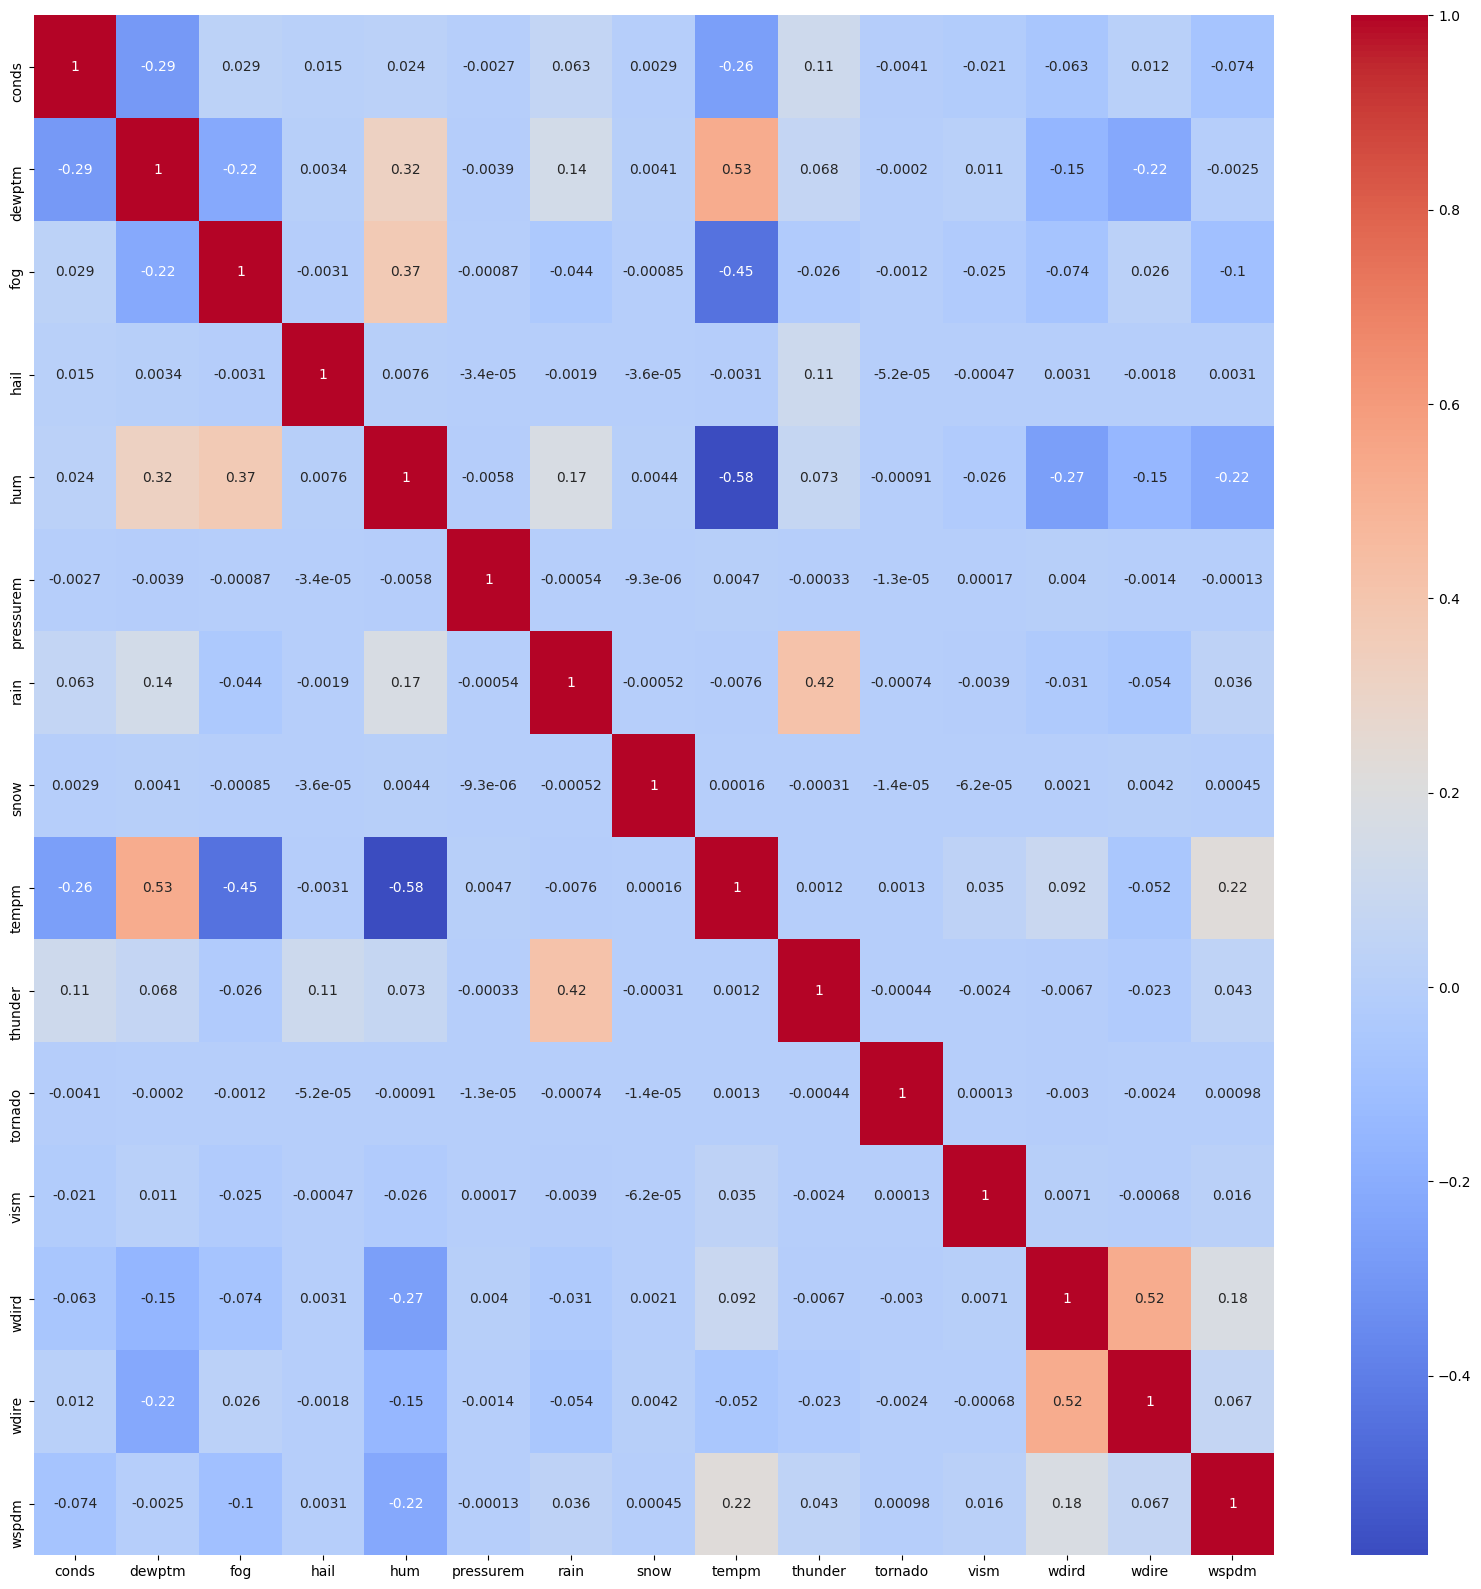

In [17]:
#Plotting a Correlations heatmap
plt.figure(figsize=(20,20))
sns.heatmap(weather.corr(),cmap='coolwarm',annot=True)
plt.show()

In [18]:
correlations = weather.corr()
correlations["tempm"].sort_values(ascending=False)

tempm        1.000000
dewptm       0.526783
wspdm        0.220101
wdird        0.091767
vism         0.034727
pressurem    0.004704
tornado      0.001293
thunder      0.001229
snow         0.000163
hail        -0.003055
rain        -0.007564
wdire       -0.052428
conds       -0.263406
fog         -0.447231
hum         -0.584771
Name: tempm, dtype: float64

It can be inferred that most features correlate with the temprature. The notable exceptions are "hail", "rain", "wdire", "conds","hum" and "fog" which have a negligible correlation (<1%).

In [19]:
X=weather.loc[:,weather.columns.drop("tempm")].values
Y=weather.loc[:,"tempm"].values

#### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)

#### Model Accuracy

In [21]:
reg.score(X, Y)

0.9161650272559051

#### Predicting test set results ( predicting Y )

In [22]:
predection = reg.predict(X)
predection

array([28.22212777, 27.93220006, 25.19592827, ..., 17.48222598,
       13.69848348, 11.25030855])

We can see that our model is giving the best possible results.

#### Mean squared error

In [23]:
from math import sqrt
from sklearn.metrics import mean_squared_error

RMSE = sqrt(mean_squared_error(Y,predection))
RMSE

2.4524981716412295

#### Coefficient of determination

In [24]:
from sklearn.metrics import r2_score
r2=r2_score(Y,predection)
adj_r2 = 1 - float(len(Y)-1)/(len(Y)-len(reg.coef_)-1)*(1 - r2)
r2, adj_r2, reg.coef_, reg.intercept_

(0.9161650272559051,
 0.9161531595779094,
 array([-5.20544382e-03,  9.66242675e-01,  1.81650226e+00,  9.63229498e-01,
        -3.08542872e-01,  7.99967000e-08,  1.45545862e+00,  1.96297643e+00,
        -1.71100572e-01,  1.20079822e+00,  1.45195738e-03, -1.66866199e-03,
         1.99778552e-02,  2.63178138e-02]),
 27.96345725919025)

#### Plotting the Weather Conditions

[]

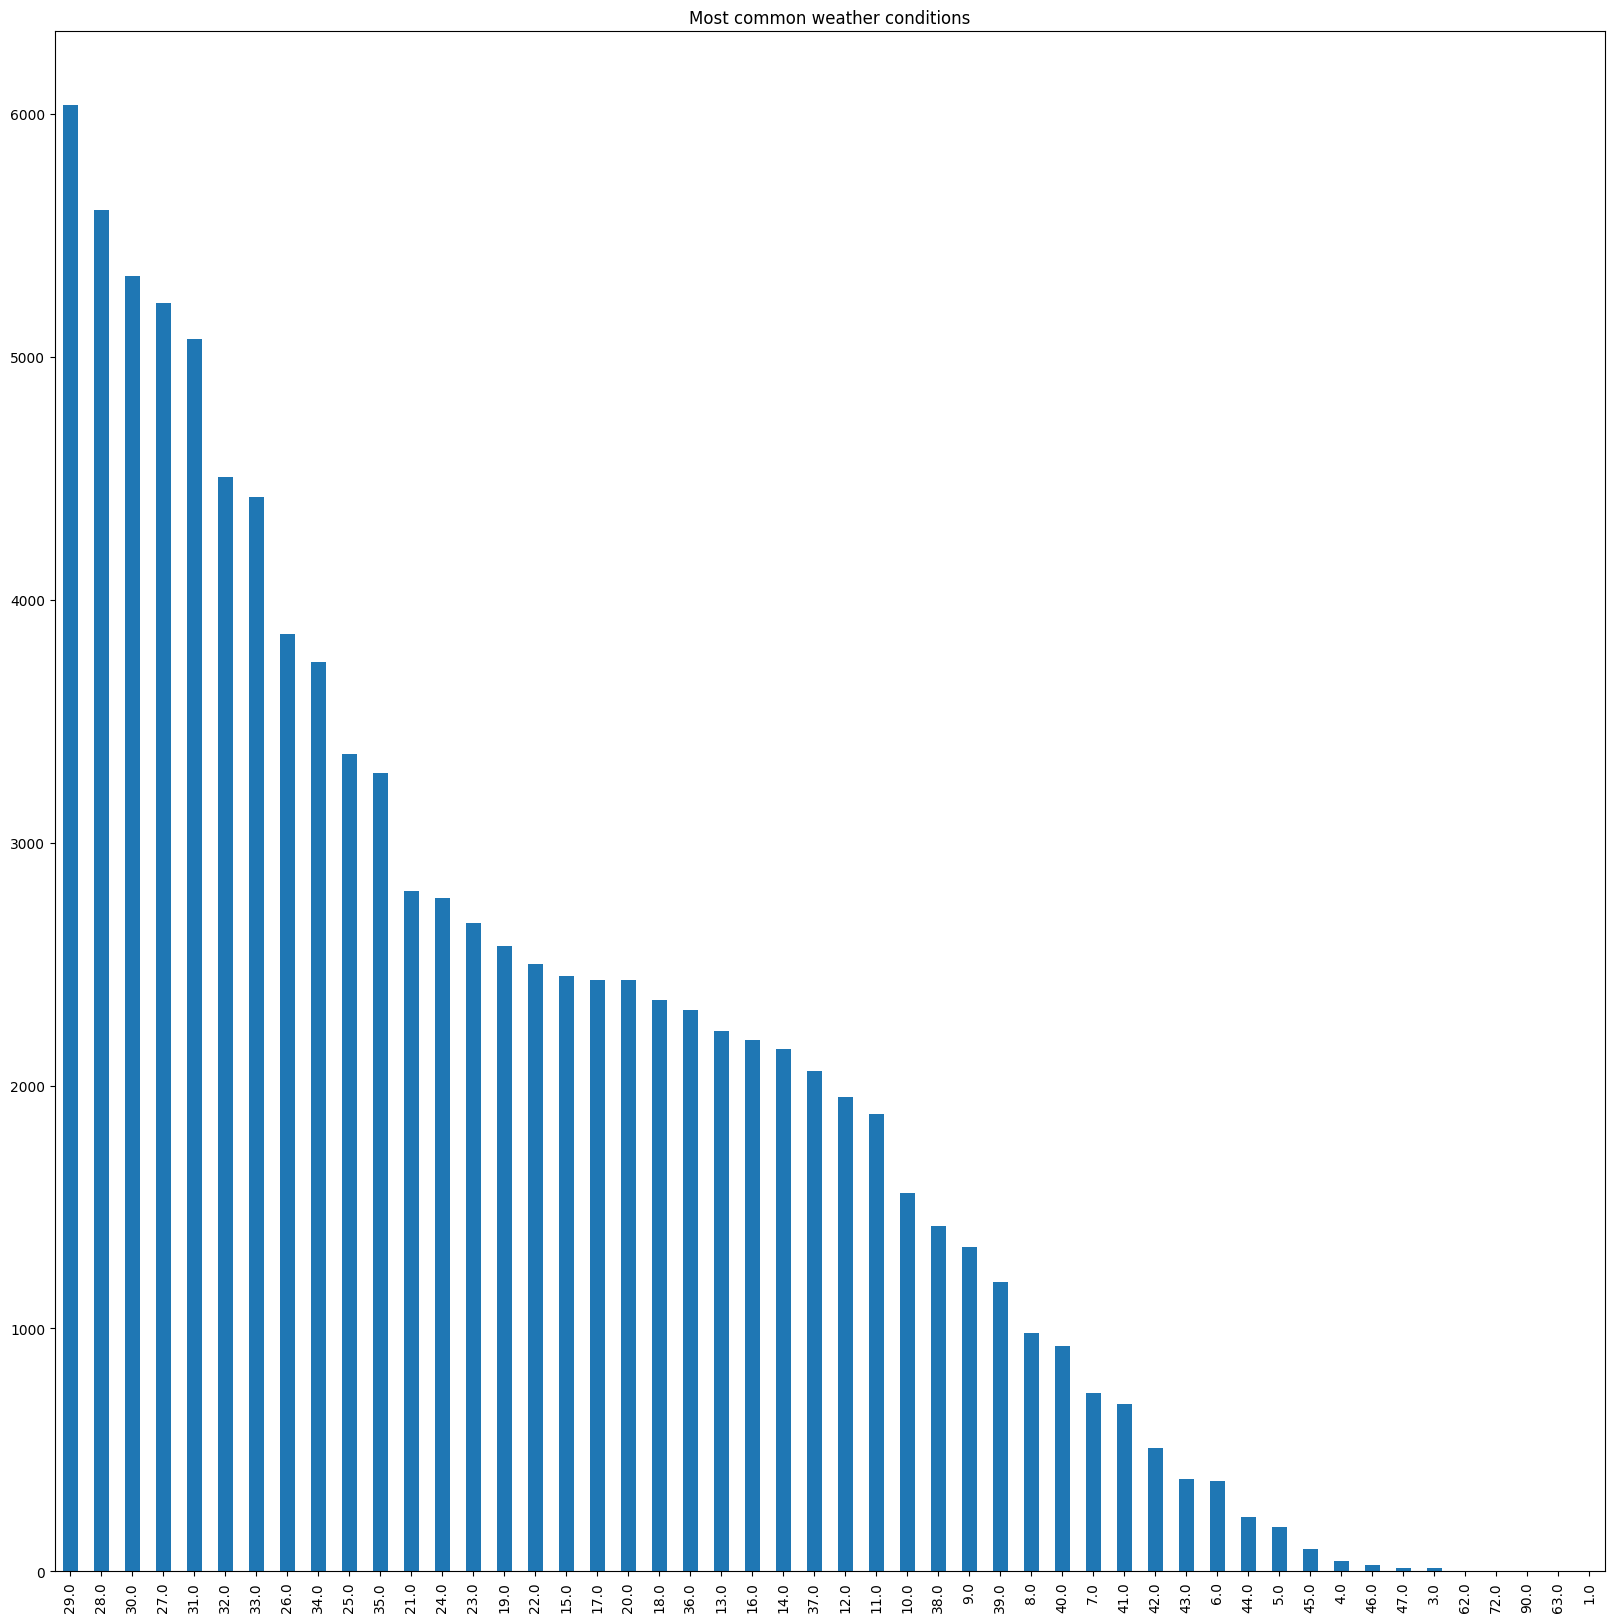

In [25]:
plt.figure(figsize=(20, 20))
plt.title('Most common weather conditions')
weather.tempm.value_counts().plot(kind='bar')
plt.plot()

#### Haze and Smoke are most common weather conditions

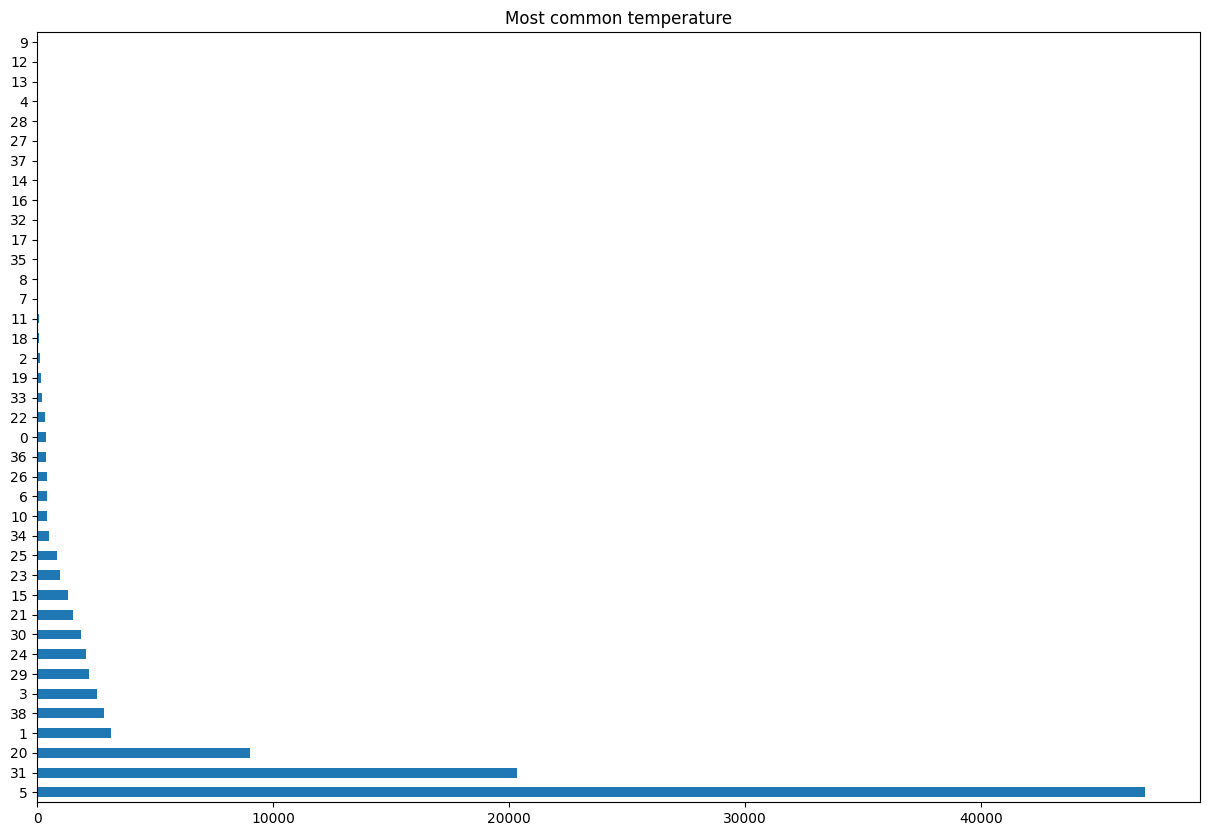

In [26]:
plt.figure(figsize=(15,10))
weather['conds'].value_counts().plot(kind='barh')
plt.title('Most common temperature')
plt.show()

#### From the plot we can observe that the most common temp in Delhi is 29 C

[]

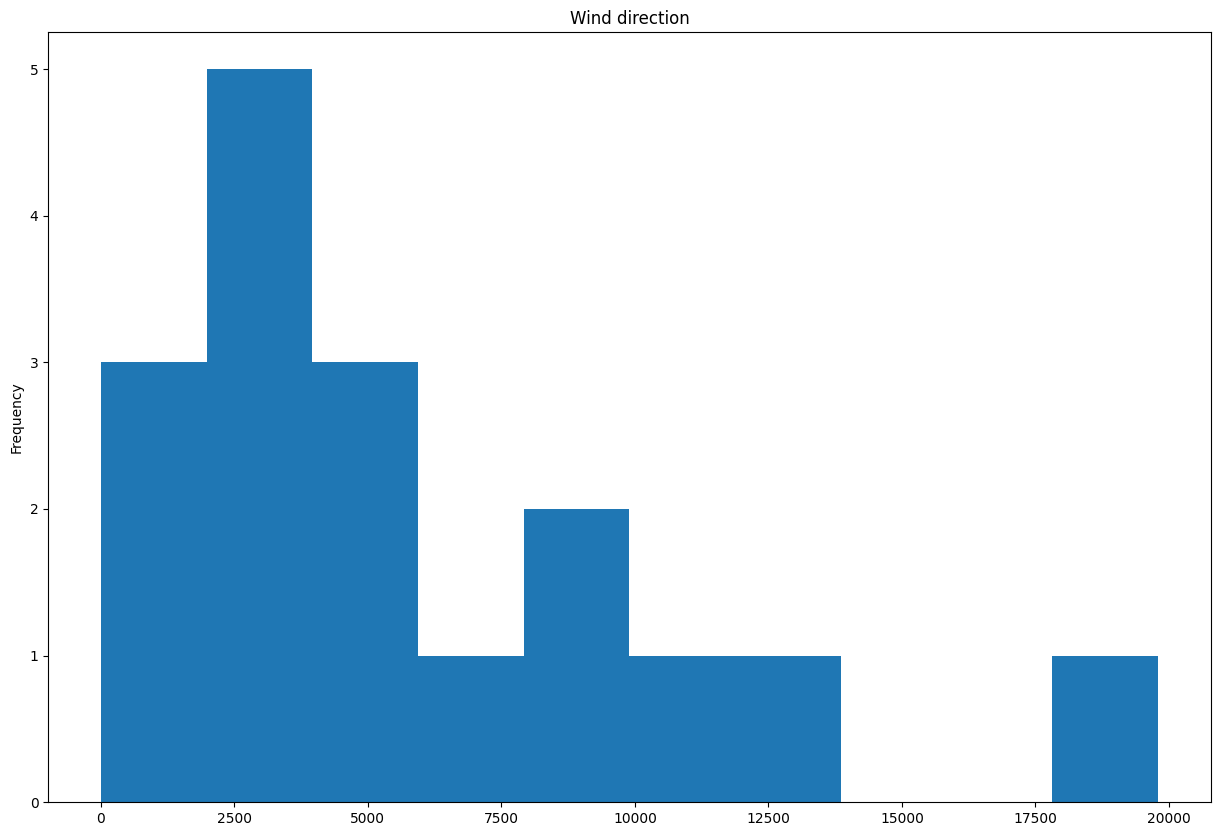

In [27]:

plt.figure(figsize=(15, 10))
plt.title("Wind direction")
weather['wdire'].value_counts().plot(kind="hist")
plt.plot()

#### Time Series Forecasting in weather

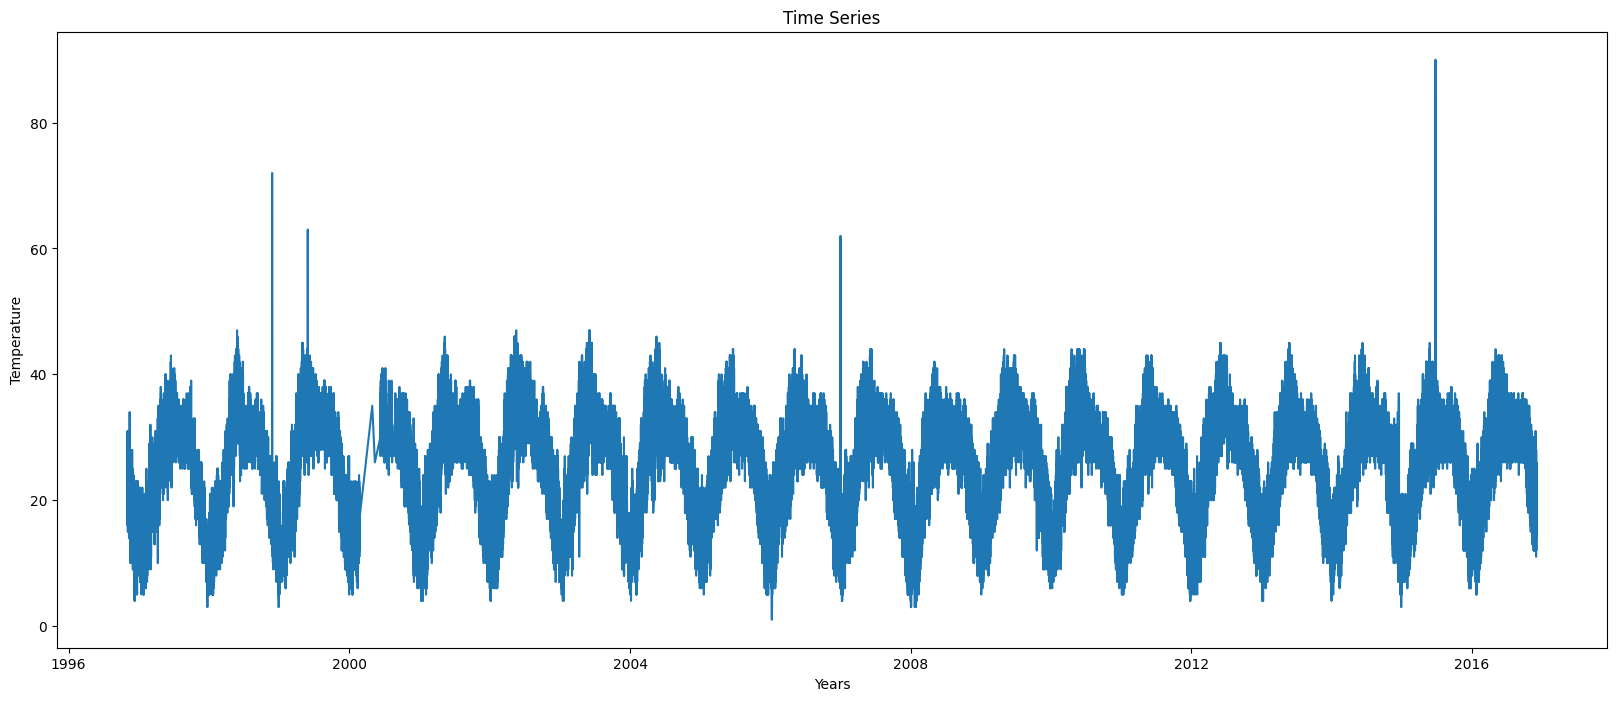

In [28]:
temp=weather.loc[:,"tempm"]


plt.figure(figsize=(20,8))
plt.plot(temp)
plt.title('Time Series')
plt.xlabel('Years')
plt.ylabel('Temperature')
plt.show()

#### Time Series Forecast using CNN-LSTMs

In [29]:
temp=temp.values
temp=temp.astype('float32')
temp

array([30., 28., 24., ..., 17., 15., 14.], dtype=float32)

In [30]:
temp=temp.reshape(-1, 1)
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(temp)

In [31]:
step = 30
a= []
b=[]
for i in range(len(sc)- (step)):
    a.append(sc[i:i+step])
    b.append(sc[i+step])
a=np.asanyarray(a)
b=np.asanyarray(b)
k = 7000
atrain = a[:k,:,:]
atest = a[k:,:,:]    
btrain = b[:k]    
btest= b[k:]
print(atrain.shape)
print(atest.shape)

(7000, 30, 1)
(91883, 30, 1)


In [32]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

In [33]:
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))

In [34]:
model.add(LSTM(100, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1))

In [35]:

model.compile(loss='mse', optimizer='adam')
model.fit(atrain,btrain,epochs=100, verbose=0)

In [36]:
preds_cnn1 = model.predict(atest)
preds_cnn1 = scaler.inverse_transform(preds_cnn1)


btest=np.asanyarray(btest)  
btest=btest.reshape(-1,1) 
btest = scaler.inverse_transform(btest)


btrain=np.asanyarray(btrain)  
btrain=btrain.reshape(-1,1) 
btrain = scaler.inverse_transform(btrain)

In [37]:

mean_squared_error(btest,preds_cnn1)

7.027838

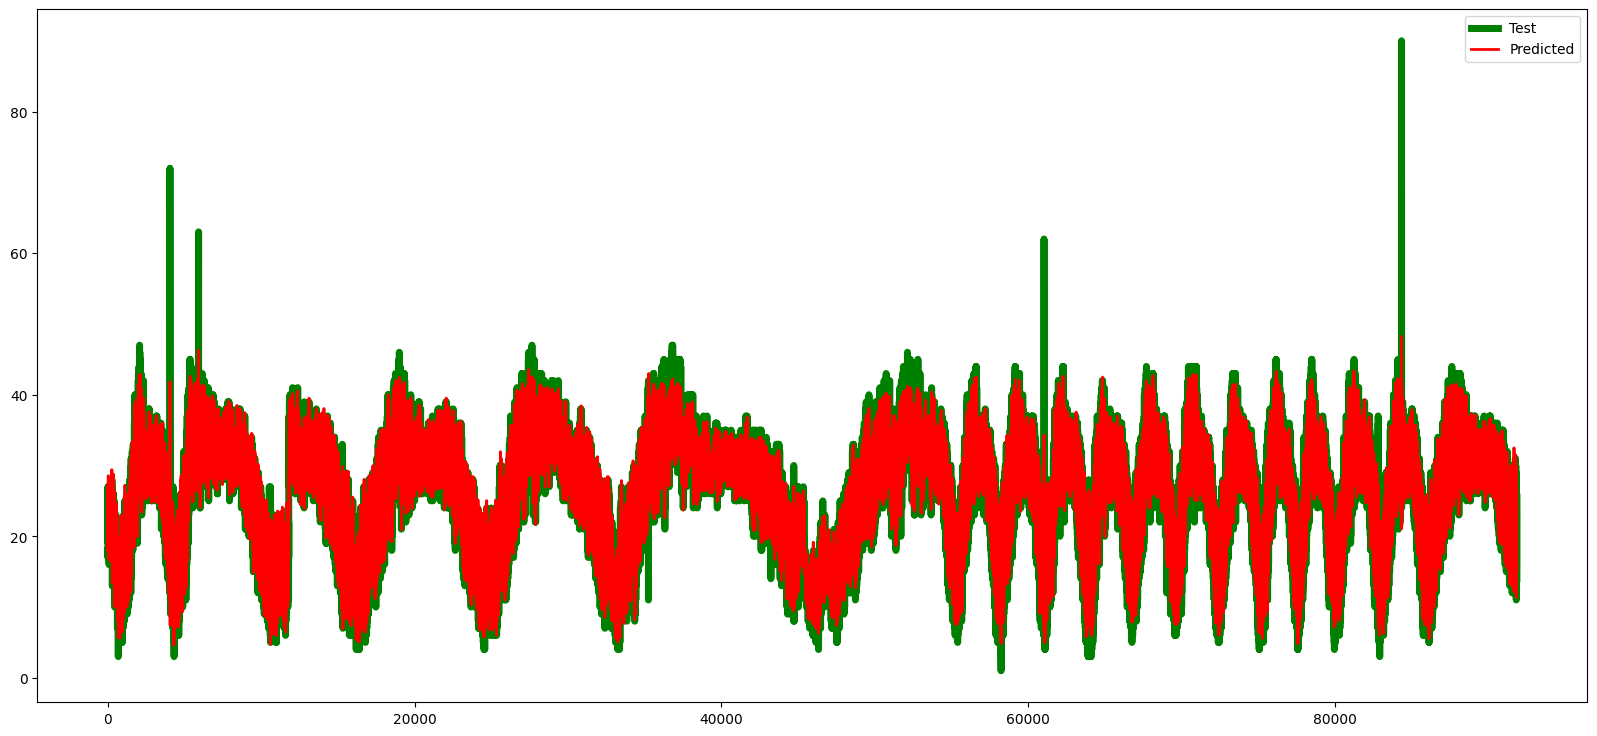

In [38]:
plt.figure(figsize=(20,9))
plt.plot(btest , 'green', linewidth=5)
plt.plot(preds_cnn1,'r' , linewidth=2)
plt.legend(('Test','Predicted'))
plt.show()